# 1. DeepWalk

## 1.1. Load dataset

In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from matplotlib import pyplot as plt 
np.random.seed(15)


#Load data
adjlist = nx.read_adjlist("./data/karate_club.adjlist", nodetype=int)
karate_label = np.loadtxt("./data/karate_label.txt")
Graph = nx.read_adjlist("./data/karate_club.adjlist", nodetype=int)
node_number = nx.to_pandas_adjacency(Graph).columns


adj = nx.to_numpy_array(adjlist)
#label = karate_label[:,-1]

print(adj.shape)
#print(label.shape)

(34, 34)


## 1.2. Activation function


In [2]:
def softmax(x):
    c = np.max(x)
    b = x-c
    exp_x = np.exp(b)
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x
    return y

### 1.3. FC layer, Random walk 

In [3]:
#Fully connected layer
class ann:
    def __init__(self, input_size, hidden_size, output_size):
        # setting the shape of the layer and putting random inital value
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, output_size)

    # Calculating the Values
    def gradient(self, x, y):
        # forward
        W1, W2 = self.params['W1'], self.params['W2']
        h = np.dot(x, W1)
        # H = softmax(U)

        U2 = np.dot(h, W2)
        Y = softmax(U2)

        diff = (Y - y)  # 34*1

        ERR2 = np.outer(h, diff)

        # backpropagation
        # ERR2 = (-np.log(np.abs(Y-y)))*Y*(1-Y)
        ERR = np.outer(x, np.dot(W2, diff))

        return ERR, ERR2, diff, Y

w = 3 #window_size w
d = 4 #embedding size d
r = 10 # walks per vertex
t = 10 # walk length
learning_rate = 0.0001

#Params
n_network = ann(input_size = 34,hidden_size = d,output_size = 34)
#P = np.random.random((34,d)) # Work as W1 (input_size,hidden_size)
#Q = np.random.random((d,34)) # work as W2 (hidden_size, input_size)

def random_walk(vertex, t):
    ans = []
    ans.append(vertex)

    while True:
        # stop untill the window size get t
        if len(ans) == t:
            return ans

        # check nearest vertexs
        vertex_adj_list = list(adj[vertex])
        near_vertex_index = np.nonzero(vertex_adj_list)

        # choose the nearess vertex randomly
        get_vertex = np.random.choice(list(near_vertex_index[0]), 1)
        ans.append(get_vertex[0])
        vertex = get_vertex[0]


def skipgram(W, w, loss):
    new_loss = np.zeros(34)
    loss = 0
    for idx, vertex in enumerate(W):
        # making u_list considering w
        start = idx - w
        end = idx + w
        if start < 0:
            start = 0
        if end >= len(W):
            end = len(W) - 1

        u_list = []
        u_list.extend(W[start:idx])
        u_list.extend(W[idx + 1:end + 1])

        # calculating each u from u_list
        for each_u in u_list:
            # input, ouput with one-hot encoding
            input_vertex = np.zeros(34)
            y_pred = np.zeros(34)
            v = vertex
            u = each_u
            input_vertex[v] = 1
            y_pred[u] = 1

            # gradient (forward,backpropa)

            ERR, ERR2, diff, Y = n_network.gradient(input_vertex, y_pred)
            # updata params
            n_network.params['W1'] -= learning_rate * ERR
            n_network.params['W2'] -= learning_rate * ERR2
            # n_network.params['W2'] -= np.reshape(learning_rate * ERR2 * H.T, (d,34))

            # calculating loss
            loss += -np.log(Y[each_u])
        # new_loss = new_loss / len(u_list)
    return loss


epoch = 100
epoch_loss2 = []
loss = np.zeros((34, 34))
for _ in range(epoch):
    epoch_loss = 0
    for i in range(r):
        O = np.arange(34)
        np.random.shuffle(O)

        for vertex in O:
            W = random_walk(vertex, t)
            loss = skipgram(W, w, loss)
            epoch_loss += (loss / len(W))

    # h = np.dot(adj[1],W1)
    # H = softmax(U)

    # U2 = np.dot(h,W2)
    # Y = softmax(U2)
    # aa = np.mean(-np.log(Y -adj[1]))
    epoch_loss2.append(np.mean(epoch_loss) / (len(O) * r))
    # calculating loss
    # n_network.params['W1']


## 1.4. Visualize random walk with t-SNE

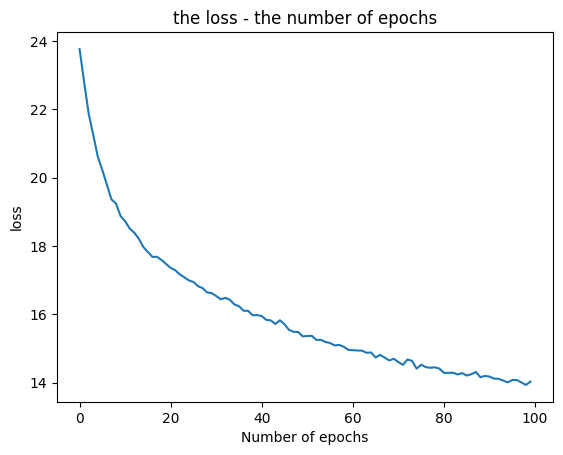

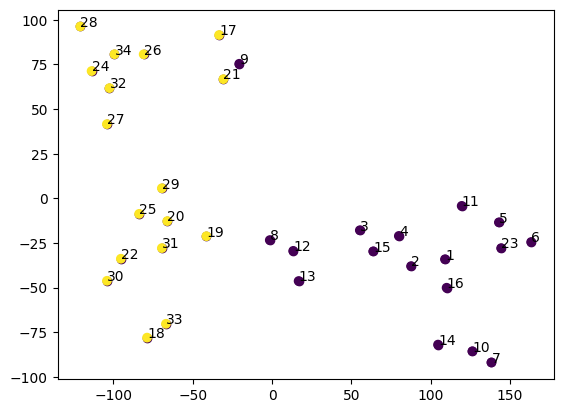

In [4]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

plt.plot(epoch_loss2)
plt.title("the loss - the number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("loss")
plt.show()

nums = np.identity(34)
W1 = n_network.params['W1']
output = np.dot(nums , W1)
adj = nx.to_numpy_array(adjlist)
label = karate_label[:,-1]


node_number
label
label_fix = []
for i in node_number:
    tem = label[i]
    label_fix.append(tem)

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(learning_rate=100,perplexity=5)
transformed = model.fit_transform(output)
xs = transformed[:,0]
ys = transformed[:,1]

for i in range(len(xs)):
    plt.scatter(xs[i],ys[i],c = node_number[i])
    plt.text(xs[i],ys[i],i+1)
plt.scatter(xs,ys,c=label_fix)
#plt.text(xs,ys)
plt.show()

# 2. node2vec

## 2.1. Random walk

In [8]:
import random
from tqdm import tqdm

# Generate random walks on the graph
def parallel_generate_walks(d_graph: dict, global_walk_length: int, num_walks: int, cpu_num: int,
                            sampling_strategy: dict = None, num_walks_key: str = None, walk_length_key: str = None,
                            neighbors_key: str = None, probabilities_key: str = None, first_travel_key: str = None,
                            quiet: bool = False) -> list:
    """
    Generates the random walks which will be used as the skip-gram input.

    :return: List of walks. Each walk is a list of nodes.
    """

    walks = list()

    if not quiet:
        pbar = tqdm(total=num_walks, desc='Generating walks (CPU: {})'.format(cpu_num))

    for n_walk in range(num_walks):

        # Update progress bar
        if not quiet:
            pbar.update(1)

        # Shuffle the nodes
        shuffled_nodes = list(d_graph.keys())
        random.shuffle(shuffled_nodes)

        # Start a random walk from every node
        for source in shuffled_nodes:

            # Skip nodes with specific num_walks
            if source in sampling_strategy and \
                    num_walks_key in sampling_strategy[source] and \
                    sampling_strategy[source][num_walks_key] <= n_walk:
                continue

            # Start walk
            walk = [source]

            # Calculate walk length
            if source in sampling_strategy:
                walk_length = sampling_strategy[source].get(walk_length_key, global_walk_length)
            else:
                walk_length = global_walk_length

            # Perform walk
            while len(walk) < walk_length:

                walk_options = d_graph[walk[-1]].get(neighbors_key, None)

                # Skip dead end nodes
                if not walk_options:
                    break

                if len(walk) == 1:  # For the first step
                    probabilities = d_graph[walk[-1]][first_travel_key]
                    walk_to = random.choices(walk_options, weights=probabilities)[0]
                else:
                    probabilities = d_graph[walk[-1]][probabilities_key][walk[-2]]
                    walk_to = random.choices(walk_options, weights=probabilities)[0]

                walk.append(walk_to)

            walk = list(map(str, walk))  # Convert all to strings

            walks.append(walk)

    if not quiet:
        pbar.close()

    return walks

In [7]:
from importlib.metadata import version

def is_dated_gensim_version():
    return version("gensim") < '4.0.0'

## 2.2. Create Node2Vec

In [4]:
import os
import random
from collections import defaultdict

import gensim
import networkx as nx
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm



class Node2Vec:
    FIRST_TRAVEL_KEY = 'first_travel_key'
    PROBABILITIES_KEY = 'probabilities'
    NEIGHBORS_KEY = 'neighbors'
    WEIGHT_KEY = 'weight'
    NUM_WALKS_KEY = 'num_walks'
    WALK_LENGTH_KEY = 'walk_length'
    P_KEY = 'p'
    Q_KEY = 'q'

    def __init__(self, graph: nx.Graph, dimensions: int = 128, walk_length: int = 80, num_walks: int = 10, p: float = 1,
                 q: float = 1, weight_key: str = 'weight', workers: int = 1, sampling_strategy: dict = None,
                 quiet: bool = False, temp_folder: str = None, seed: int = None):
        """
        Initiates the Node2Vec object, precomputes walking probabilities and generates the walks.

        :param graph: Input graph
        :param dimensions: Embedding dimensions (default: 128)
        :param walk_length: Number of nodes in each walk (default: 80)
        :param num_walks: Number of walks per node (default: 10)
        :param p: Return hyper parameter (default: 1)
        :param q: Inout parameter (default: 1)
        :param weight_key: On weighted graphs, this is the key for the weight attribute (default: 'weight')
        :param workers: Number of workers for parallel execution (default: 1)
        :param sampling_strategy: Node specific sampling strategies, supports setting node specific 'q', 'p', 'num_walks' and 'walk_length'.
        :param seed: Seed for the random number generator.
        Use these keys exactly. If not set, will use the global ones which were passed on the object initialization
        :param temp_folder: Path to folder with enough space to hold the memory map of self.d_graph (for big graphs); to be passed joblib.Parallel.temp_folder
        """

        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.weight_key = weight_key
        self.workers = workers
        self.quiet = quiet
        self.d_graph = defaultdict(dict)

        if sampling_strategy is None:
            self.sampling_strategy = {}
        else:
            self.sampling_strategy = sampling_strategy

        self.temp_folder, self.require = None, None
        if temp_folder:
            if not os.path.isdir(temp_folder):
                raise NotADirectoryError("temp_folder does not exist or is not a directory. ({})".format(temp_folder))

            self.temp_folder = temp_folder
            self.require = "sharedmem"

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self._precompute_probabilities()
        self.walks = self._generate_walks()

    def _precompute_probabilities(self):
        """
        Precomputes transition probabilities for each node.
        """

        d_graph = self.d_graph

        nodes_generator = self.graph.nodes() if self.quiet \
            else tqdm(self.graph.nodes(), desc='Computing transition probabilities')

        for source in nodes_generator:

            # Init probabilities dict for first travel
            if self.PROBABILITIES_KEY not in d_graph[source]:
                d_graph[source][self.PROBABILITIES_KEY] = dict()

            for current_node in self.graph.neighbors(source):

                # Init probabilities dict
                if self.PROBABILITIES_KEY not in d_graph[current_node]:
                    d_graph[current_node][self.PROBABILITIES_KEY] = dict()

                unnormalized_weights = list()
                d_neighbors = list()

                # Calculate unnormalized weights
                for destination in self.graph.neighbors(current_node):

                    p = self.sampling_strategy[current_node].get(self.P_KEY,
                                                                 self.p) if current_node in self.sampling_strategy else self.p
                    q = self.sampling_strategy[current_node].get(self.Q_KEY,
                                                                 self.q) if current_node in self.sampling_strategy else self.q

                    try:
                        if self.graph[current_node][destination].get(self.weight_key):
                            weight = self.graph[current_node][destination].get(self.weight_key, 1)
                        else: 
                            ## Example : AtlasView({0: {'type': 1, 'weight':0.1}})- when we have edge weight
                            edge = list(self.graph[current_node][destination])[-1]
                            weight = self.graph[current_node][destination][edge].get(self.weight_key, 1)
                            
                    except:
                        weight = 1 
                    
                    if destination == source:  # Backwards probability
                        ss_weight = weight * 1 / p
                    elif destination in self.graph[source]:  # If the neighbor is connected to the source
                        ss_weight = weight
                    else:
                        ss_weight = weight * 1 / q

                    # Assign the unnormalized sampling strategy weight, normalize during random walk
                    unnormalized_weights.append(ss_weight)
                    d_neighbors.append(destination)

                # Normalize
                unnormalized_weights = np.array(unnormalized_weights)
                d_graph[current_node][self.PROBABILITIES_KEY][
                    source] = unnormalized_weights / unnormalized_weights.sum()

            # Calculate first_travel weights for source
            first_travel_weights = []

            for destination in self.graph.neighbors(source):
                first_travel_weights.append(self.graph[source][destination].get(self.weight_key, 1))

            first_travel_weights = np.array(first_travel_weights)
            d_graph[source][self.FIRST_TRAVEL_KEY] = first_travel_weights / first_travel_weights.sum()

            # Save neighbors
            d_graph[source][self.NEIGHBORS_KEY] = list(self.graph.neighbors(source))

    def _generate_walks(self) -> list:
        """
        Generates the random walks which will be used as the skip-gram input.
        :return: List of walks. Each walk is a list of nodes.
        """

        flatten = lambda l: [item for sublist in l for item in sublist]

        # Split num_walks for each worker
        num_walks_lists = np.array_split(range(self.num_walks), self.workers)

        walk_results = Parallel(n_jobs=self.workers, temp_folder=self.temp_folder, require=self.require)(
            delayed(parallel_generate_walks)(self.d_graph,
                                             self.walk_length,
                                             len(num_walks),
                                             idx,
                                             self.sampling_strategy,
                                             self.NUM_WALKS_KEY,
                                             self.WALK_LENGTH_KEY,
                                             self.NEIGHBORS_KEY,
                                             self.PROBABILITIES_KEY,
                                             self.FIRST_TRAVEL_KEY,
                                             self.quiet) for
            idx, num_walks
            in enumerate(num_walks_lists, 1))

        walks = flatten(walk_results)

        return walks
    
    

    def fit(self, **skip_gram_params) -> gensim.models.Word2Vec:
        """
        Creates the embeddings using gensim's Word2Vec.
        :param skip_gram_params: Parameters for gensim.models.Word2Vec - do not supply 'size' / 'vector_size' it is
            taken from the Node2Vec 'dimensions' parameter
        :type skip_gram_params: dict
        :return: A gensim word2vec model
        """

        if 'workers' not in skip_gram_params:
            skip_gram_params['workers'] = self.workers

        # Figure out gensim version, naming of output dimensions changed from size to vector_size in v4.0.0
        size = 'size' if is_dated_gensim_version() else 'vector_size'
        if size not in skip_gram_params:
            skip_gram_params[size] = self.dimensions

        if 'sg' not in skip_gram_params:
            skip_gram_params['sg'] = 1

        return gensim.models.Word2Vec(self.walks, **skip_gram_params)
    
    

In [5]:
def parallel_generate_walks(d_graph, walk_length, num_walks, idx, sampling_strategy,
                            NUM_WALKS_KEY, WALK_LENGTH_KEY, NEIGHBORS_KEY,
                            PROBABILITIES_KEY, FIRST_TRAVEL_KEY, quiet):
    """
    Generates random walks for a subset of the total number of walks (used for parallel processing).

    :param d_graph: Precomputed probability graph
    :param walk_length: Length of each walk
    :param num_walks: Number of walks to generate
    :param idx: Worker index
    :param sampling_strategy: Per-node sampling strategy
    :param quiet: Whether to disable tqdm progress
    :return: List of walks
    """

    walks = []
    nodes = list(d_graph.keys())
    rng = np.random.default_rng(seed=idx)  # Deterministic random for reproducibility

    iterator = range(num_walks)
    if not quiet:
        iterator = tqdm(iterator, desc=f'Worker {idx} generating walks')

    for _ in iterator:
        rng.shuffle(nodes)
        for start_node in nodes:
            curr_walk_length = sampling_strategy.get(start_node, {}).get(WALK_LENGTH_KEY, walk_length)
            walk = [start_node]

            if len(d_graph[start_node][NEIGHBORS_KEY]) == 0:
                continue

            # First step
            first_probs = d_graph[start_node][FIRST_TRAVEL_KEY]
            first_neighbors = d_graph[start_node][NEIGHBORS_KEY]
            next_node = rng.choice(first_neighbors, p=first_probs)
            walk.append(next_node)

            for _ in range(curr_walk_length - 2):
                prev = walk[-2]
                curr = walk[-1]

                neighbors = d_graph[curr][NEIGHBORS_KEY]
                if len(neighbors) == 0:
                    break

                probs = d_graph[curr][PROBABILITIES_KEY][prev]
                next_node = rng.choice(neighbors, p=probs)
                walk.append(next_node)

            walks.append(walk)

    return walks


## 2.3. Run Node2Vec to generate embeddings 

In [8]:
# Load the Karate Club graph
G = nx.karate_club_graph()

# Initialize Node2Vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Fit the model to the data
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get the embedding of each node
node_embeddings = model.wv.vectors

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Worker 3 generating walks: 100%|██████████| 50/50 [00:00<00:00, 176.95it/s]


## 2.4. Visualize Node2Vec embeddings

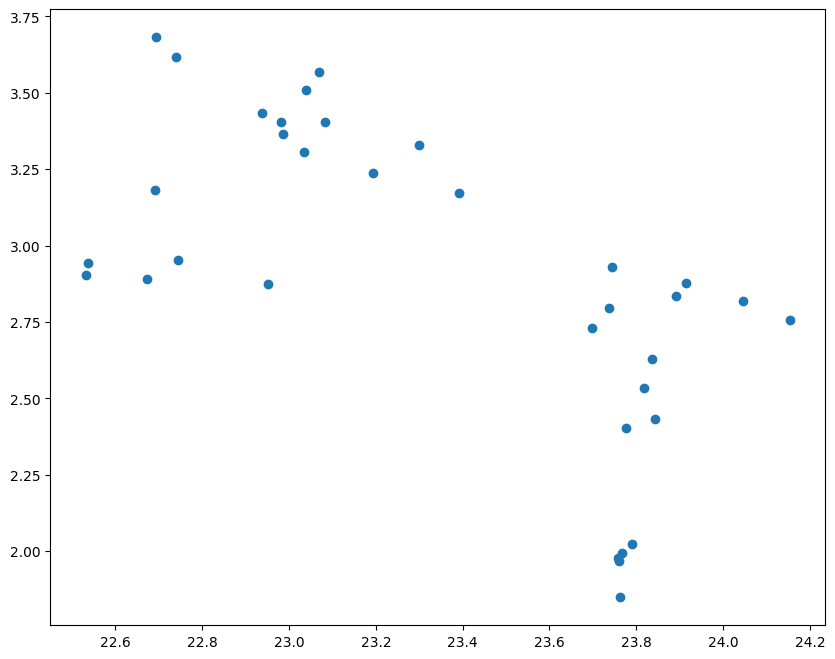

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Use t-SNE to reduce the dimensionality of the embeddings to 2D
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Visualize the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1])
plt.show()

# 3. node2vec+

In [10]:
import os
import random
from collections import defaultdict

import gensim
import networkx as nx
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm


class Node2VecPlus:
    FIRST_TRAVEL_KEY = 'first_travel_key'
    PROBABILITIES_KEY = 'probabilities'
    NEIGHBORS_KEY = 'neighbors'
    WEIGHT_KEY = 'weight'
    EDGE_FEATURES_KEY = 'edge_features'  # Main difference
    NUM_WALKS_KEY = 'num_walks'
    WALK_LENGTH_KEY = 'walk_length'
    P_KEY = 'p'
    Q_KEY = 'q'

    def __init__(self, graph: nx.Graph, dimensions: int = 128, walk_length: int = 80, num_walks: int = 10, p: float = 1,
                 q: float = 1, weight_key: str = 'weight', edge_features_key: str = None, workers: int = 1,
                 sampling_strategy: dict = None, quiet: bool = False, temp_folder: str = None, seed: int = None):
        """
        Initiates the Node2VecPlus object, precomputes walking probabilities and generates the walks.

        :param graph: Input graph
        :param dimensions: Embedding dimensions (default: 128)
        :param walk_length: Number of nodes in each walk (default: 80)
        :param num_walks: Number of walks per node (default: 10)
        :param p: Return hyper parameter (default: 1)
        :param q: Inout parameter (default: 1)
        :param weight_key: On weighted graphs, this is the key for the weight attribute (default: 'weight')
        :param edge_features_key: Key for edge features if any (default: None)
        :param workers: Number of workers for parallel execution (default: 1)
        :param sampling_strategy: Node specific sampling strategies, supports setting node specific 'q', 'p', 'num_walks' and 'walk_length'
        :param seed: Seed for the random number generator
        :param temp_folder: Path to folder with enough space to hold the memory map of self.d_graph (for big graphs); to be passed joblib.Parallel.temp_folder
        """

        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.weight_key = weight_key
        self.edge_features_key = edge_features_key
        self.workers = workers
        self.quiet = quiet
        self.d_graph = defaultdict(dict)
        self.E = 1e-7

        if sampling_strategy is None:
            self.sampling_strategy = {}
        else:
            self.sampling_strategy = sampling_strategy

        self.temp_folder, self.require = None, None
        if temp_folder:
            if not os.path.isdir(temp_folder):
                raise NotADirectoryError("temp_folder does not exist or is not a directory. ({})".format(temp_folder))

            self.temp_folder = temp_folder
            self.require = "sharedmem"

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self._precompute_probabilities()
        self.walks = self._generate_walks()

    def _precompute_probabilities(self):
        """
        Precomputes transition probabilities for each node, including edge features.
        """

        d_graph = self.d_graph

        nodes_generator = self.graph.nodes() if self.quiet \
            else tqdm(self.graph.nodes(), desc='Computing transition probabilities')

        def calculate_normalized_weights(graph, y, E):
            normalized_weights = {}
            for v in graph.nodes():
                for u in graph.neighbors(v):
                    edge_weights = [graph[v][u].get('weight', 1) for u in graph.neighbors(v)]
                    mean_weight = np.mean(edge_weights)
                    std_weight = np.std(edge_weights)
                    a_v = mean_weight + y * std_weight
                    w_vu = graph[v][u].get('weight', 1)
                    wy_vu = w_vu / max(a_v, E)
                    normalized_weights[(v, u)] = wy_vu
                    normalized_weights[(u, v)] = wy_vu 
            return normalized_weights

        y = 1
        for source in nodes_generator:
            normalized_weights = calculate_normalized_weights(self.graph, y, self.E)

            # Init probabilities dict for first travel
            if self.PROBABILITIES_KEY not in d_graph[source]:
                d_graph[source][self.PROBABILITIES_KEY] = dict()

            for current_node in self.graph.neighbors(source):

                # Init probabilities dict
                if self.PROBABILITIES_KEY not in d_graph[current_node]:
                    d_graph[current_node][self.PROBABILITIES_KEY] = dict()

                unnormalized_weights = list()
                d_neighbors = list()

                # Calculate unnormalized weights
                for destination in self.graph.neighbors(current_node):

                    p = self.sampling_strategy[current_node].get(self.P_KEY,
                                                                 self.p) if current_node in self.sampling_strategy else self.p
                    q = self.sampling_strategy[current_node].get(self.Q_KEY,
                                                                 self.q) if current_node in self.sampling_strategy else self.q

                    try:
                        if self.graph[current_node][destination].get(self.weight_key):
                            weight = self.graph[current_node][destination].get(self.weight_key, 1)
                        else:
                            # Handle different graph data structures with edge weights
                            edge = list(self.graph[current_node][destination])[-1]
                            weight = self.graph[current_node][destination][edge].get(self.weight_key, 1)
                    except:
                        weight = 1

                    # Calculate bias factor
                    if destination == source:  # Case 1: 1/p
                        ss_weight = 1 / p
                    elif normalized_weights.get((destination, source), 0) >= 1:  # Case 2: 1
                        ss_weight = 1
                    elif normalized_weights.get((destination, source), 0) < 1 and normalized_weights.get((source, destination), 0) < 1:  # Case 3: min{1,1/q}
                        ss_weight = min(1, 1 / q)
                    elif normalized_weights.get((destination, source), 0) < 1 and normalized_weights.get((source, destination), 0) >= 1:  # Case 4: 1/q + (1 - 1/q)*normalized of edge weight
                        ss_weight = 1 / q + (1 - 1 / q) * normalized_weights.get((destination, source), 1)

                    # Incorporate edge features if provided
                    if self.edge_features_key:
                        edge_features = self.graph[current_node][destination].get(self.edge_features_key, 1)
                        ss_weight *= edge_features

                    # Assign the unnormalized sampling strategy weight, normalize during random walk
                    unnormalized_weights.append(ss_weight)
                    d_neighbors.append(destination)

                # Normalize
                if unnormalized_weights:
                    unnormalized_weights = np.array(unnormalized_weights)
                    d_graph[current_node][self.PROBABILITIES_KEY][
                        source] = unnormalized_weights / unnormalized_weights.sum()

            # Calculate first_travel weights for source
            first_travel_weights = []

            for destination in self.graph.neighbors(source):
                first_travel_weights.append(self.graph[source][destination].get(self.weight_key, 1))

            if first_travel_weights:
                first_travel_weights = np.array(first_travel_weights)
                d_graph[source][self.FIRST_TRAVEL_KEY] = first_travel_weights / first_travel_weights.sum()

            # Save neighbors
            d_graph[source][self.NEIGHBORS_KEY] = list(self.graph.neighbors(source))

    def _generate_walks(self) -> list:
        """
        Generates the random walks which will be used as the skip-gram input.
        :return: List of walks. Each walk is a list of nodes.
        """

        flatten = lambda l: [item for sublist in l for item in sublist]

        # Split num_walks for each worker
        num_walks_lists = np.array_split(range(self.num_walks), self.workers)

        walk_results = Parallel(n_jobs=self.workers, temp_folder=self.temp_folder, require=self.require)(
            delayed(self._parallel_generate_walks)(self.d_graph,
                                                   self.walk_length,
                                                   len(num_walks),
                                                   idx,
                                                   self.sampling_strategy,
                                                   self.NUM_WALKS_KEY,
                                                   self.WALK_LENGTH_KEY,
                                                   self.NEIGHBORS_KEY,
                                                   self.PROBABILITIES_KEY,
                                                   self.FIRST_TRAVEL_KEY,
                                                   self.quiet) for
            idx, num_walks
            in enumerate(num_walks_lists, 1))

        walks = flatten(walk_results)

        return walks

    def _parallel_generate_walks(self, d_graph, walk_length, num_walks, idx, sampling_strategy,
                                 NUM_WALKS_KEY, WALK_LENGTH_KEY, NEIGHBORS_KEY, PROBABILITIES_KEY, FIRST_TRAVEL_KEY, quiet):
        """
        Helper function to generate walks in parallel.
        """
        walks = []
        for _ in tqdm(range(num_walks), desc=f'Generating walks (worker {idx})', disable=quiet):
            for node in d_graph:
                walk = [node]
                while len(walk) < walk_length:
                    cur = walk[-1]
                    cur_nbrs = d_graph[cur][NEIGHBORS_KEY]
                    if len(walk) == 1:
                        walk.append(np.random.choice(cur_nbrs, p=d_graph[cur][FIRST_TRAVEL_KEY]))
                    else:
                        prev = walk[-2]
                        next_node = np.random.choice(cur_nbrs, p=d_graph[cur][PROBABILITIES_KEY][prev])
                        walk.append(next_node)
                walks.append(walk)
        return walks

    def fit(self, **skip_gram_params) -> gensim.models.Word2Vec:
        """
        Creates the embeddings using gensim's Word2Vec.
        :param skip_gram_params: Parameters for gensim.models.Word2Vec - do not supply 'size' / 'vector_size' it is
            taken from the Node2Vec 'dimensions' parameter
        :type skip_gram_params: dict
        :return: A gensim word2vec model
        """

        if 'workers' not in skip_gram_params:
            skip_gram_params['workers'] = self.workers

        # Figure out gensim version, naming of output dimensions changed from size to vector_size in v4.0.0
        size = 'size' if gensim.__version__ < '4.0.0' else 'vector_size'
        if size not in skip_gram_params:
            skip_gram_params[size] = self.dimensions

        if 'seed' not in skip_gram_params and hasattr(self, 'seed'):
            skip_gram_params['seed'] = self.seed

        model = gensim.models.Word2Vec(sentences=self.walks, **skip_gram_params)
        return model

## 3.1. Run Div2Vec to generate embeddings 

In [11]:
# Example usage
G = nx.karate_club_graph()
node2vecplus = Node2VecPlus(G, dimensions=64, walk_length=30, num_walks=200, workers=4, edge_features_key=1)
model = node2vecplus.fit(window=10, min_count=1, batch_words=4)

# Get the embedding of each node
node_embeddings = model.wv.vectors

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (worker 2): 100%|██████████| 50/50 [00:00<00:00, 194.79it/s]


## 3.2. Visualize Node2VecPlus embedding

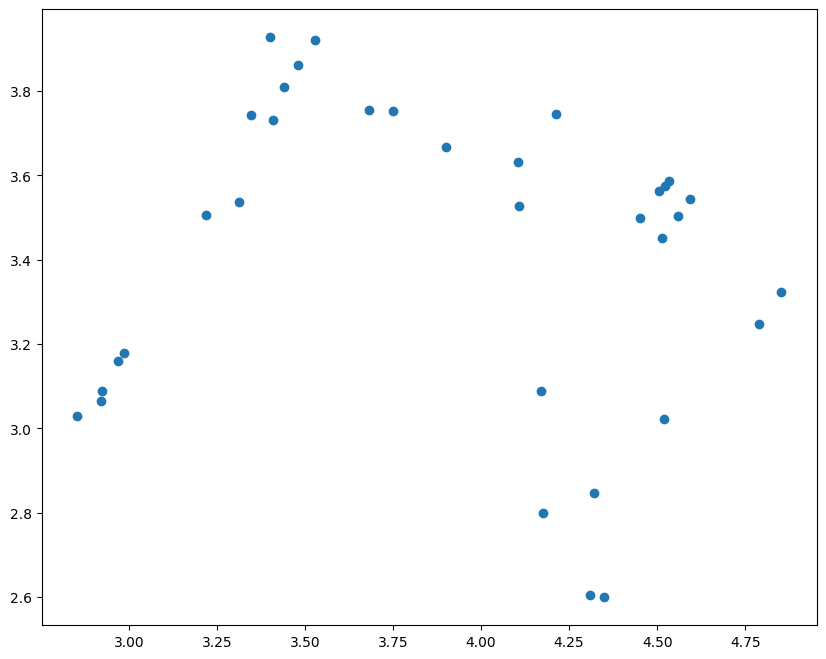

In [12]:
# Use t-SNE to reduce the dimensionality of the embeddings to 2D
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Visualize the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1])
plt.show()

# 4. Walklets

### Utils for data reading and writing

In [13]:
import argparse
import pandas as pd
import networkx as nx

def parameter_parser():
    """
    A method to parse up command line parameters.
    By default it gives an embedding of the Facebook food dataset.
    The default hyperparameters give a good quality representation without grid search.
    Representations are sorted by ID.
    """
    parser = argparse.ArgumentParser(description="Run Walklet.")

    parser.add_argument("--input",
                        nargs="?",
                        default="./input/food_edges.csv",
	                help="Input folder with jsons.")

    parser.add_argument("--output",
                        nargs="?",
                        default="./output/food_embedding.csv",
	                help="Embeddings path.")

    parser.add_argument("--walk-type",
                        nargs="?",
                        default="second",
	                help="Random walk order.")

    parser.add_argument("--dimensions",
                        type=int,
                        default=16,
	                help="Number of dimensions. Default is 16.")

    parser.add_argument("--walk-number",
                        type=int,
                        default=5,
	                help="Number of walks. Default is 5.")

    parser.add_argument("--walk-length",
                        type=int,
                        default=80,
	                help="Walk length. Default is 80.")

    parser.add_argument("--window-size",
                        type=int,
                        default=5,
	                help="Number of embeddings. Default is 5.")

    parser.add_argument("--workers",
                        type=int,
                        default=4,
	                help="Number of cores. Default is 4.")

    parser.add_argument("--min-count",
                        type=int,
                        default=1,
	                help="Minimal appearance feature count. Default is 1.")

    parser.add_argument("--P",
                        type=float,
                        default=1.0,
	                help="Return hyperparameter. Default is 1.0.")

    parser.add_argument("--Q",
                        type=float,
                        default=1.0,
	                help="Inout hyperparameter. Default is 1.0.")

    return parser.parse_args()

def create_graph(file_name):
    """
    Reading an adjacency list file and returning an Nx graph object.
    :param file_name: location of the adjacency list file.
    :return graph: Networkx graph object.
    """
    graph = nx.read_adjlist(file_name)
    return graph


def walk_transformer(walk, length):
    """
    Tranforming a given random walk to have skips.
    :param walk: Random walk as a list.
    :param length: Skip size.
    :return transformed_walk: Walk chunks for training.
    """
    transformed_walk = []
    for step in range(length+1):
        neighbors = [y for i, y in enumerate(walk[step:]) if i % length == 0]
        transformed_walk.append(neighbors)
    return transformed_walk

## 4.1. Walker classes

In [14]:
import random
import numpy as np
import networkx as nx
from tqdm import tqdm

class FirstOrderRandomWalker:
    """
    Class to do fast first-order random walks.
    """
    def __init__(self, graph, args):
        """
        Constructor for FirstOrderRandomWalker.
        :param graph: Nx graph object.
        :param args: Arguments object.
        """
        self.graph = graph
        self.walk_length = args.walk_length
        self.walk_number = args.walk_number
        self.walks = []

    def do_walk(self, node):
        """
        Doing a single truncated random walk from a source node.
        :param node: Source node of the truncated random walk.
        :return walk: A single random walk.
        """
        walk = [node]
        for _ in range(self.walk_length-1):
            nebs = [node for node in self.graph.neighbors(walk[-1])]
            if len(nebs) > 0:
                walk = walk + random.sample(nebs, 1)
        walk = [str(w) for w in walk]
        return walk

    def do_walks(self):
        """
        Doing a fixed number of truncated random walk from every node in the graph.
        """
        print("\nModel initialized.\nRandom walks started.")
        for iteration in range(self.walk_number):
            print("\nRandom walk round: "+str(iteration+1)+"/"+str(self.walk_number)+".\n")
            for node in tqdm(self.graph.nodes()):
                walk_from_node = self.do_walk(node)
                self.walks.append(walk_from_node)
        return self.walks

class SecondOrderRandomWalker:
    """
    Class to do second-order random walks.
    """
    def __init__(self, nx_G, is_directed, args):
        """
        Constructor for SecondOrderRandomWalker.
        :param  nx_G: Nx graph object.
        :param is_directed: Directed nature of the graph -- True/False.
        :param args: Arguments object.
        """
        self.G = nx_G
        self.nodes = nx.nodes(self.G)
        print("Edge weighting.\n")
        for edge in tqdm(self.G.edges()):
            self.G[edge[0]][edge[1]]['weight'] = 1.0
            self.G[edge[1]][edge[0]]['weight'] = 1.0
        self.is_directed = is_directed
        self.walk_length = args.walk_length
        self.walk_number = args.walk_number
        self.p = args.P
        self.q = args.Q

    def node2vec_walk(self, start_node):
        """
        Simulate a random walk starting from start node.
        """
        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        while len(walk) < self.walk_length:
            cur = walk[-1]
            cur_n = sorted(G.neighbors(cur))
            if len(cur_n) > 0:
                if len(walk) == 1:
                    walk.append(cur_n[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    pre = walk[-2]
                    next = cur_n[alias_draw(alias_edges[(pre, cur)][0], alias_edges[(pre, cur)][1])]
                    walk.append(next)
            else:
                break
        walk = [str(w) for w in walk]
        return walk

    def do_walks(self):
        """
        Repeatedly simulate random walks from each node.
        """
        G = self.G
        walks = []
        nodes = list(G.nodes())
        for walk_it in range(self.walk_number):
            print("\nRandom walk round: "+str(walk_it+1)+"/"+str(self.walk_number)+".\n")
            random.shuffle(nodes)
            for node in tqdm(nodes):
                walks.append(self.node2vec_walk(start_node=node))

        return walks

    def get_alias_edge(self, src, dst):
        """
        Get the alias edge setup lists for a given edge.
        """
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        for dst_nbr in sorted(G.neighbors(dst)):
            if dst_nbr == src:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
            elif G.has_edge(dst_nbr, src):
                unnormalized_probs.append(G[dst][dst_nbr]['weight'])
            else:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
        norm_const = sum(unnormalized_probs)
        normalized_probs = [float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return alias_setup(normalized_probs)

    def preprocess_transition_probs(self):
        """
        Preprocessing of transition probabilities for guiding the random walks.
        """
        G = self.G
        is_directed = self.is_directed

        alias_nodes = {}
        print("")
        print("Preprocesing.\n")
        for node in tqdm(G.nodes()):
            unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = alias_setup(normalized_probs)

        alias_edges = {}
        triads = {}

        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        else:
            for edge in tqdm(G.edges()):
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
                alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges

        return

def alias_setup(probs):
    """
    Compute utility lists for non-uniform sampling from discrete distributions.
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)
    smaller = []
    larger = []

    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q):
    """
    Draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand()*K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


## 4.2. Walklet

In [15]:
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec

class WalkletMachine:
    """
    Walklet multi-scale graph factorization machine class.
    The graph is being parsed up, random walks are initiated.
    Embeddings are fitted, concatenated and the multi-scale embedding is dumped to disk.
    """
    def __init__(self, args):
        """
        Walklet machine constructor.
        :param args: Arguments object with the model hyperparameters.
        """
        self.args = args
        self.graph = create_graph(self.args.input)
        if self.args.walk_type == "first":
            self.walker = FirstOrderRandomWalker(self.graph, args)
        else:
            self.walker = SecondOrderRandomWalker(self.graph, False, args)
            self.walker.preprocess_transition_probs()
        self.walks = self.walker.do_walks()
        del self.walker
        self.create_embedding()
        self.save_model()

    def walk_extracts(self, length):
        """
        Extracted walks with skip equal to the length.
        :param length: Length of the skip to be used.
        :return good_walks: The attenuated random walks.
        """
        good_walks = [walk_transformer(walk, length) for walk in self.walks]
        good_walks = [w for walks in good_walks for w in walks]
        return good_walks

    def get_embedding(self, model):
        """
        Extracting the embedding according to node order from the embedding model.
        :param model: A Word2Vec model after model fitting.
        :return embedding: A numpy array with the embedding sorted by node IDs.
        """
        embedding = []
        for node in range(len(self.graph.nodes())):
            embedding.append(list(model.wv[str(node)]))  # Use model.wv to access word vectors
        embedding = np.array(embedding)
        return embedding


    def create_embedding(self):
        """
        Creating a multi-scale embedding.
        """
        self.embedding = []
        for index in range(1, self.args.window_size + 1):
            print("\nOptimization round: " + str(index) + "/" + str(self.args.window_size) + ".")
            print("Creating documents.")
            clean_documents = self.walk_extracts(index)
            print("Fitting model.")

            model = Word2Vec(clean_documents,
                            vector_size=self.args.dimensions,  # Use vector_size instead of size
                            window=1,
                            min_count=self.args.min_count,
                            sg=1,
                            workers=self.args.workers)

            new_embedding = self.get_embedding(model)
            self.embedding = self.embedding + [new_embedding]
        self.embedding = np.concatenate(self.embedding, axis=1)


    def save_model(self):
        """
        Saving the embedding as a csv with sorted IDs.
        """
        print("\nModels are integrated to be multi scale.\nSaving to disk.")
        self.column_names = ["x_" + str(x) for x in range(self.embedding.shape[1])]
        self.embedding = pd.DataFrame(self.embedding, columns=self.column_names)
        self.embedding.to_csv(self.args.output, index=None)

## 4.3. Create Arguments Object

In [16]:
class Args:
    def __init__(self, input_graph, output, dimensions, window_size, walk_type, min_count, workers, walk_length, walk_number):
        self.input = input_graph
        self.output = output
        self.dimensions = dimensions
        self.window_size = window_size
        self.walk_type = walk_type
        self.min_count = min_count
        self.workers = workers
        self.walk_length = walk_length  
        self.walk_number = walk_number  


## 4.4. Initialize and Run WalkletMachine then Visualize the Embeddings


Model initialized.
Random walks started.

Random walk round: 1/80.



100%|██████████| 34/34 [00:00<00:00, 93819.96it/s]



Random walk round: 2/80.



100%|██████████| 34/34 [00:00<00:00, 100144.90it/s]



Random walk round: 3/80.



100%|██████████| 34/34 [00:00<00:00, 41992.44it/s]



Random walk round: 4/80.



100%|██████████| 34/34 [00:00<00:00, 98146.14it/s]



Random walk round: 5/80.



100%|██████████| 34/34 [00:00<00:00, 99169.91it/s]



Random walk round: 6/80.



100%|██████████| 34/34 [00:00<00:00, 99377.24it/s]



Random walk round: 7/80.



100%|██████████| 34/34 [00:00<00:00, 97675.57it/s]



Random walk round: 8/80.



100%|██████████| 34/34 [00:00<00:00, 96355.63it/s]



Random walk round: 9/80.



100%|██████████| 34/34 [00:00<00:00, 94191.77it/s]



Random walk round: 10/80.



100%|██████████| 34/34 [00:00<00:00, 91122.26it/s]



Random walk round: 11/80.



100%|██████████| 34/34 [00:00<00:00, 99032.18it/s]



Random walk round: 12/80.



100%|██████████| 34/34 [00:00<00:00, 99446.54it/s]



Random walk round: 13/80.



100%|██████████| 34/34 [00:00<00:00, 97608.72it/s]



Random walk round: 14/80.



100%|██████████| 34/34 [00:00<00:00, 100144.90it/s]



Random walk round: 15/80.



100%|██████████| 34/34 [00:00<00:00, 98689.51it/s]



Random walk round: 16/80.



100%|██████████| 34/34 [00:00<00:00, 96616.76it/s]



Random walk round: 17/80.



100%|██████████| 34/34 [00:00<00:00, 90200.09it/s]



Random walk round: 18/80.



100%|██████████| 34/34 [00:00<00:00, 88685.53it/s]



Random walk round: 19/80.



100%|██████████| 34/34 [00:00<00:00, 92601.52it/s]



Random walk round: 20/80.



100%|██████████| 34/34 [00:00<00:00, 91238.86it/s]



Random walk round: 21/80.



100%|██████████| 34/34 [00:00<00:00, 88465.47it/s]



Random walk round: 22/80.



100%|██████████| 34/34 [00:00<00:00, 94566.54it/s]



Random walk round: 23/80.



100%|██████████| 34/34 [00:00<00:00, 90086.13it/s]



Random walk round: 24/80.



100%|██████████| 34/34 [00:00<00:00, 44370.36it/s]



Random walk round: 25/80.



100%|██████████| 34/34 [00:00<00:00, 55989.92it/s]



Random walk round: 26/80.



100%|██████████| 34/34 [00:00<00:00, 44328.98it/s]



Random walk round: 27/80.



100%|██████████| 34/34 [00:00<00:00, 38762.25it/s]



Random walk round: 28/80.



100%|██████████| 34/34 [00:00<00:00, 58758.28it/s]



Random walk round: 29/80.



100%|██████████| 34/34 [00:00<00:00, 54492.29it/s]



Random walk round: 30/80.



100%|██████████| 34/34 [00:00<00:00, 56860.58it/s]



Random walk round: 31/80.



100%|██████████| 34/34 [00:00<00:00, 59197.32it/s]



Random walk round: 32/80.



100%|██████████| 34/34 [00:00<00:00, 59099.19it/s]



Random walk round: 33/80.



100%|██████████| 34/34 [00:00<00:00, 58661.59it/s]



Random walk round: 34/80.



100%|██████████| 34/34 [00:00<00:00, 59969.02it/s]



Random walk round: 35/80.



100%|██████████| 34/34 [00:00<00:00, 78701.07it/s]



Random walk round: 36/80.



100%|██████████| 34/34 [00:00<00:00, 87542.26it/s]



Random walk round: 37/80.



100%|██████████| 34/34 [00:00<00:00, 99238.93it/s]



Random walk round: 38/80.



100%|██████████| 34/34 [00:00<00:00, 77757.00it/s]



Random walk round: 39/80.



100%|██████████| 34/34 [00:00<00:00, 86062.97it/s]



Random walk round: 40/80.



100%|██████████| 34/34 [00:00<00:00, 84382.45it/s]



Random walk round: 41/80.



100%|██████████| 34/34 [00:00<00:00, 95837.59it/s]



Random walk round: 42/80.



100%|██████████| 34/34 [00:00<00:00, 96945.16it/s]



Random walk round: 43/80.



100%|██████████| 34/34 [00:00<00:00, 98621.26it/s]



Random walk round: 44/80.



100%|██████████| 34/34 [00:00<00:00, 99934.36it/s]



Random walk round: 45/80.



100%|██████████| 34/34 [00:00<00:00, 91180.52it/s]



Random walk round: 46/80.



100%|██████████| 34/34 [00:00<00:00, 95007.55it/s]



Random walk round: 47/80.



100%|██████████| 34/34 [00:00<00:00, 94818.04it/s]



Random walk round: 48/80.



100%|██████████| 34/34 [00:00<00:00, 57595.45it/s]



Random walk round: 49/80.



100%|██████████| 34/34 [00:00<00:00, 82288.71it/s]



Random walk round: 50/80.



100%|██████████| 34/34 [00:00<00:00, 92004.09it/s]



Random walk round: 51/80.



100%|██████████| 34/34 [00:00<00:00, 90257.17it/s]



Random walk round: 52/80.



100%|██████████| 34/34 [00:00<00:00, 79535.05it/s]



Random walk round: 53/80.



100%|██████████| 34/34 [00:00<00:00, 91708.25it/s]



Random walk round: 54/80.



100%|██████████| 34/34 [00:00<00:00, 95773.23it/s]



Random walk round: 55/80.



100%|██████████| 34/34 [00:00<00:00, 84783.79it/s]



Random walk round: 56/80.



100%|██████████| 34/34 [00:00<00:00, 93024.35it/s]



Random walk round: 57/80.



100%|██████████| 34/34 [00:00<00:00, 89689.52it/s]



Random walk round: 58/80.



100%|██████████| 34/34 [00:00<00:00, 99377.24it/s]



Random walk round: 59/80.



100%|██████████| 34/34 [00:00<00:00, 88685.53it/s]



Random walk round: 60/80.



100%|██████████| 34/34 [00:00<00:00, 41930.71it/s]



Random walk round: 61/80.



100%|██████████| 34/34 [00:00<00:00, 98011.23it/s]



Random walk round: 62/80.



100%|██████████| 34/34 [00:00<00:00, 96747.85it/s]



Random walk round: 63/80.



100%|██████████| 34/34 [00:00<00:00, 89184.70it/s]



Random walk round: 64/80.



100%|██████████| 34/34 [00:00<00:00, 91649.32it/s]



Random walk round: 65/80.



100%|██████████| 34/34 [00:00<00:00, 98757.85it/s]



Random walk round: 66/80.



100%|██████████| 34/34 [00:00<00:00, 56232.78it/s]



Random walk round: 67/80.



100%|██████████| 34/34 [00:00<00:00, 97608.72it/s]



Random walk round: 68/80.



100%|██████████| 34/34 [00:00<00:00, 58831.00it/s]



Random walk round: 69/80.



100%|██████████| 34/34 [00:00<00:00, 92721.93it/s]



Random walk round: 70/80.



100%|██████████| 34/34 [00:00<00:00, 88962.16it/s]



Random walk round: 71/80.



100%|██████████| 34/34 [00:00<00:00, 84834.23it/s]



Random walk round: 72/80.



100%|██████████| 34/34 [00:00<00:00, 95261.41it/s]



Random walk round: 73/80.



100%|██████████| 34/34 [00:00<00:00, 98146.14it/s]



Random walk round: 74/80.



100%|██████████| 34/34 [00:00<00:00, 89915.72it/s]



Random walk round: 75/80.



100%|██████████| 34/34 [00:00<00:00, 88028.60it/s]



Random walk round: 76/80.



100%|██████████| 34/34 [00:00<00:00, 81722.83it/s]



Random walk round: 77/80.



100%|██████████| 34/34 [00:00<00:00, 84935.28it/s]



Random walk round: 78/80.



100%|██████████| 34/34 [00:00<00:00, 48604.75it/s]



Random walk round: 79/80.



100%|██████████| 34/34 [00:00<00:00, 57665.32it/s]



Random walk round: 80/80.



100%|██████████| 34/34 [00:00<00:00, 69025.33it/s]


Optimization round: 1/5.
Creating documents.
Fitting model.

Optimization round: 2/5.
Creating documents.
Fitting model.

Optimization round: 3/5.
Creating documents.
Fitting model.



Optimization round: 4/5.
Creating documents.
Fitting model.

Optimization round: 5/5.
Creating documents.
Fitting model.

Models are integrated to be multi scale.
Saving to disk.


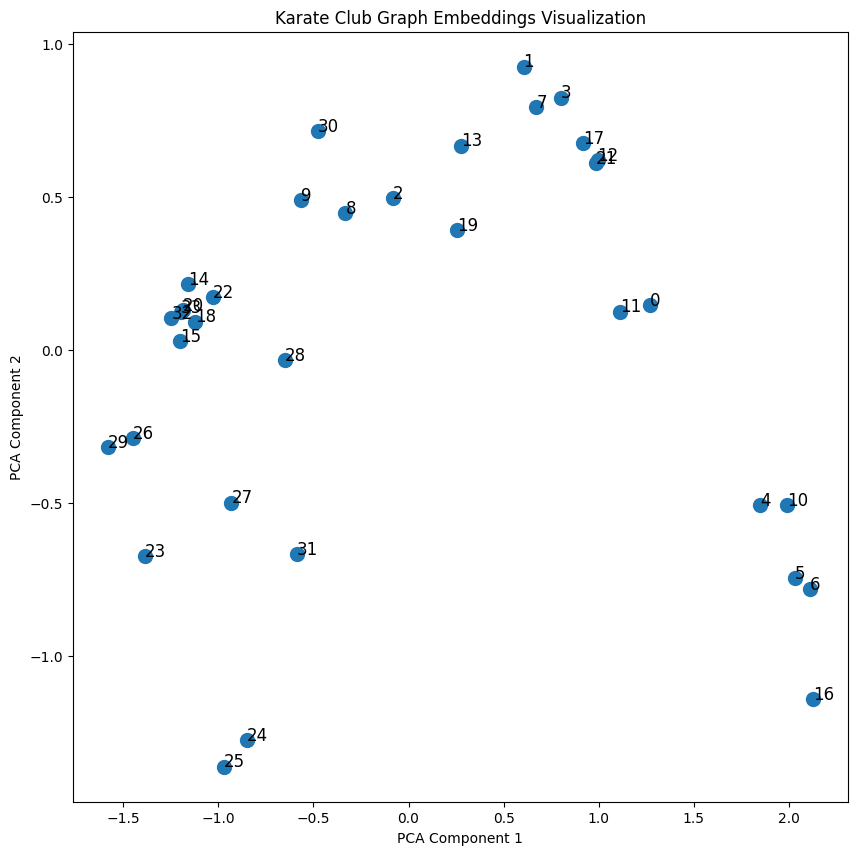

In [19]:
# Create a graph using the karate club dataset
karate_club_graph = nx.karate_club_graph()

# Save the graph in adjacency list format
nx.write_adjlist(karate_club_graph, "karate_club.adjlist")

# Define the arguments for the WalkletMachine
args = Args(input_graph="karate_club.adjlist",
            output="karate_club_embedding.csv",
            dimensions=128,
            window_size=5,
            walk_type="first",
            min_count=1,
            workers=4,
            walk_length=10,   # Set the walk length
            walk_number=80)   # Set the number of walks

# Instantiate and run the WalkletMachine
walklet_machine = WalkletMachine(args)

# Load the embeddings from the saved CSV
embeddings = pd.read_csv("karate_club_embedding.csv")

# Use PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Create a scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=100)

# Annotate points with their node IDs
for i, txt in enumerate(karate_club_graph.nodes()):
    plt.annotate(txt, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=12)

plt.title("Karate Club Graph Embeddings Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# 5. Div2vec

In [20]:
class Div2Vec:
    FIRST_TRAVEL_KEY = 'first_travel_key'
    PROBABILITIES_KEY = 'probabilities'
    NEIGHBORS_KEY = 'neighbors'
    WEIGHT_KEY = 'weight' #Main difference
    NUM_WALKS_KEY = 'num_walks'
    WALK_LENGTH_KEY = 'walk_length'
    P_KEY = 'p'
    Q_KEY = 'q'
    DIVERSITY_FACTOR_KEY = 'diversity_factor' #Main difference

    # Initialize the Div2Vec object, precompute walking probabilities, and generate the walks
    def __init__(self, graph: nx.Graph, dimensions: int = 128, walk_length: int = 80, num_walks: int = 10, p: float = 1,
                 q: float = 1, diversity_factor: float = 1.0, weight_key: str = 'weight', workers: int = 1, 
                 sampling_strategy: dict = None, quiet: bool = False, temp_folder: str = None, seed: int = None):
        """
        Initiates the Div2Vec object, precomputes walking probabilities and generates the walks.

        :param graph: Input graph
        :param dimensions: Embedding dimensions (default: 128)
        :param walk_length: Number of nodes in each walk (default: 80)
        :param num_walks: Number of walks per node (default: 10)
        :param p: Return hyper parameter (default: 1)
        :param q: Inout parameter (default: 1)
        :param diversity_factor: Factor to penalize revisits within the same walk (default: 1.0)
        :param weight_key: On weighted graphs, this is the key for the weight attribute (default: 'weight')
        :param workers: Number of workers for parallel execution (default: 1)
        :param sampling_strategy: Node specific sampling strategies, supports setting node specific 'q', 'p', 'num_walks' and 'walk_length'.
        :param seed: Seed for the random number generator.
        :param temp_folder: Path to folder with enough space to hold the memory map of self.d_graph (for big graphs); to be passed joblib.Parallel.temp_folder
        """

        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.diversity_factor = diversity_factor
        self.weight_key = weight_key
        self.workers = workers
        self.quiet = quiet
        self.d_graph = defaultdict(dict)

        if sampling_strategy is None:
            self.sampling_strategy = {}
        else:
            self.sampling_strategy = sampling_strategy

        self.temp_folder, self.require = None, None
        if temp_folder:
            if not os.path.isdir(temp_folder):
                raise NotADirectoryError("temp_folder does not exist or is not a directory. ({})".format(temp_folder))

            self.temp_folder = temp_folder
            self.require = "sharedmem"

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self._precompute_probabilities()
        self.walks = self._generate_walks()

    # Precompute transition probabilities for each node in the graph. Calculate unnormalized weights for each destination node and normalize them
    def _precompute_probabilities(self):
        """
        Precomputes transition probabilities for each node.
        """

        d_graph = self.d_graph

        nodes_generator = self.graph.nodes() if self.quiet \
            else tqdm(self.graph.nodes(), desc='Computing transition probabilities')

        for source in nodes_generator:

            # Init probabilities dict for first travel
            if self.PROBABILITIES_KEY not in d_graph[source]:
                d_graph[source][self.PROBABILITIES_KEY] = dict()

            for current_node in self.graph.neighbors(source):

                # Init probabilities dict
                if self.PROBABILITIES_KEY not in d_graph[current_node]:
                    d_graph[current_node][self.PROBABILITIES_KEY] = dict()

                unnormalized_weights = list()
                d_neighbors = list()

                # Calculate unnormalized weights
                for destination in self.graph.neighbors(current_node):

                    p = self.sampling_strategy[current_node].get(self.P_KEY,
                                                                 self.p) if current_node in self.sampling_strategy else self.p
                    q = self.sampling_strategy[current_node].get(self.Q_KEY,
                                                                 self.q) if current_node in self.sampling_strategy else self.q

                    try:
                        if self.graph[current_node][destination].get(self.weight_key):
                            weight = self.graph[current_node][destination].get(self.weight_key, 1)
                        else: 
                            # Handle different graph data structures with edge weights
                            edge = list(self.graph[current_node][destination])[-1]
                            weight = self.graph[current_node][destination][edge].get(self.weight_key, 1)
                    except:
                        weight = 1
                    
                    # Calculate the degree of the destination node
                    degree = self.graph.degree(destination)
                    
                    # Use the degree-based function for the weight
                    ss_weight = 1 / degree

                    unnormalized_weights.append(ss_weight)
                    d_neighbors.append(destination)

                # Probability choose next node
                unnormalized_weights = np.array(unnormalized_weights)
                d_graph[current_node][self.PROBABILITIES_KEY][
                    source] = unnormalized_weights / unnormalized_weights.sum()


            # Calculate first_travel weights for source
            first_travel_weights = []

            for destination in self.graph.neighbors(source):
                first_travel_weights.append(self.graph[source][destination].get(self.weight_key, 1))

            first_travel_weights = np.array(first_travel_weights)
            d_graph[source][self.FIRST_TRAVEL_KEY] = first_travel_weights / first_travel_weights.sum()

            # Save neighbors
            d_graph[source][self.NEIGHBORS_KEY] = list(self.graph.neighbors(source))

    def _generate_walks(self) -> list:
        """
        Generates the random walks which will be used as the skip-gram input.
        :return: List of walks. Each walk is a list of nodes.
        """

        flatten = lambda l: [item for sublist in l for item in sublist]

        # Split num_walks for each worker
        num_walks_lists = np.array_split(range(self.num_walks), self.workers)

        walk_results = Parallel(n_jobs=self.workers, temp_folder=self.temp_folder, require=self.require)(
            delayed(self._parallel_generate_walks)(self.d_graph,
                                                   self.walk_length,
                                                   len(num_walks),
                                                   idx,
                                                   self.sampling_strategy,
                                                   self.NUM_WALKS_KEY,
                                                   self.WALK_LENGTH_KEY,
                                                   self.NEIGHBORS_KEY,
                                                   self.PROBABILITIES_KEY,
                                                   self.FIRST_TRAVEL_KEY,
                                                   self.diversity_factor,
                                                   self.quiet) for
            idx, num_walks
            in enumerate(num_walks_lists, 1))

        walks = flatten(walk_results)

        return walks

    def _parallel_generate_walks(self, d_graph, walk_length, num_walks, idx, sampling_strategy, 
                                 NUM_WALKS_KEY, WALK_LENGTH_KEY, NEIGHBORS_KEY, PROBABILITIES_KEY, 
                                 FIRST_TRAVEL_KEY, diversity_factor, quiet):
        """
        Helper function to generate walks in parallel.
        """
        walks = []
        for _ in tqdm(range(num_walks), desc=f'Generating walks (worker {idx})', disable=quiet):
            for node in d_graph:
                walk = [node]
                while len(walk) < walk_length:
                    cur = walk[-1]
                    cur_nbrs = d_graph[cur][NEIGHBORS_KEY]
                    if len(walk) == 1:
                        next_node = np.random.choice(cur_nbrs, p=d_graph[cur][FIRST_TRAVEL_KEY])
                    else:
                        prev = walk[-2]
                        probabilities = d_graph[cur][PROBABILITIES_KEY][prev]
                        if diversity_factor < 1.0:
                            # Penalize already visited nodes to promote diversity
                            probabilities = self._apply_diversity_penalty(probabilities, cur_nbrs, walk, diversity_factor)
                        next_node = np.random.choice(cur_nbrs, p=probabilities)
                    walk.append(next_node)
                walks.append(walk)
        return walks

    def _apply_diversity_penalty(self, probabilities, neighbors, walk, diversity_factor):
        """
        Applies a penalty to the probabilities of nodes that have already been visited in the current walk.
        """
        visit_counts = defaultdict(int)
        for node in walk:
            visit_counts[node] += 1

        penalized_probabilities = np.array(probabilities)
        for i, neighbor in enumerate(neighbors):
            if visit_counts[neighbor] > 0:
                penalized_probabilities[i] *= (diversity_factor ** visit_counts[neighbor])

        penalized_probabilities /= penalized_probabilities.sum()
        return penalized_probabilities

    def fit(self, **skip_gram_params) -> gensim.models.Word2Vec:
        """
        Creates the embeddings using gensim's Word2Vec.
        :param skip_gram_params: Parameters for gensim.models.Word2Vec - do not supply 'size' / 'vector_size' it is
            taken from the Div2Vec 'dimensions' parameter
        :type skip_gram_params: dict
        :return: A gensim word2vec model
        """

        if 'workers' not in skip_gram_params:
            skip_gram_params['workers'] = self.workers

        # Figure out gensim version, naming of output dimensions changed from size to vector_size in v4.0.0
        size = 'size' if gensim.__version__ < '4.0.0' else 'vector_size'
        if size not in skip_gram_params:
            skip_gram_params[size] = self.dimensions

        if 'seed' not in skip_gram_params and hasattr(self, 'seed'):
            skip_gram_params['seed'] = self.seed

        model = gensim.models.Word2Vec(sentences=self.walks, **skip_gram_params)
        return model

## 5.1. Generating random walk and run Div2Vec to generate embeddings 


In [21]:
div2vec = Div2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4, diversity_factor=0.5)

# Fit the model to the data
model = div2vec.fit(window=10, min_count=1, batch_words=4)

# Get the embedding of each node
node_embeddings = model.wv.vectors


Generating walks (worker 3): 100%|██████████| 50/50 [00:00<00:00, 111.26it/s]


## 5.2. Visualize embeddings 

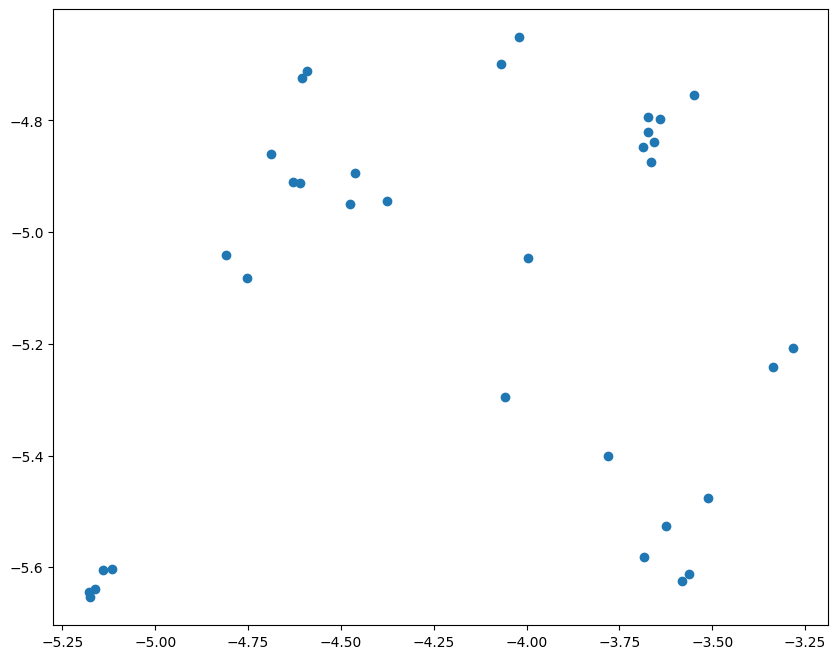

In [22]:
# Use t-SNE to reduce the dimensionality of the embeddings to 2D
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Visualize the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1])
plt.show()